In [22]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz,pickle, yaml
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr, concat, drone, bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
import beamcals.reduce_ccclass as rc
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)


In [28]:
# Creating my colormap function 

def ColorMap(cmap, number):
    cmap = cm.get_cmap(cmap, number)    
    hex_codes=[]
    
    
    for i in range(cmap.N):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba
        hex_code=matplotlib.colors.rgb2hex(rgba)
        hex_codes.append(hex_code)
    
    return hex_codes
    
    
ColorMap('viridis',5)






['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']

In [2]:
cdat = '20210824T151215Z'

20210824T151241Z /hirax/GBO_Aug_2021/TONE_ACQ/20210824T151215Z_yale_drone/corr/20210824T151241Z/ /hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/20210824T151215Z_yale_drone_yale_digitalgain/
Initializing drone data via datcon_csv routine: FLY493.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 2292/2292 non-nan values
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
DONE reading in drone data
2021-08-24 15:58:06.796000+00:00 2021-08-24 16:01:56.568000+00:00
plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [0:-1]


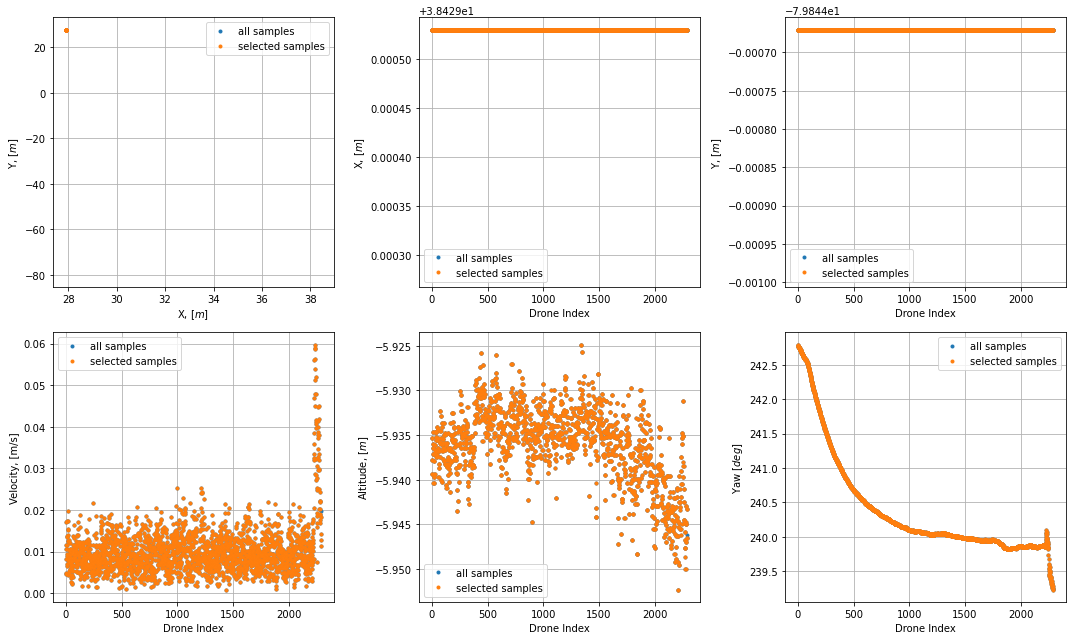

20210824T151215Z
start time:  2023-07-13 09:22:15.321861
Initializing Correlator Class using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210824T151215Z_yale_drone/corr/20210824T151241Z/
  --> Arrays initialized with shape (104, 256, 1024, 8)
Assigning array values by reading in data files:
  --> Loading File: 0103/0103
  --> Finished. Reshaping arrays.
end time:  2023-07-13 09:23:51.035241


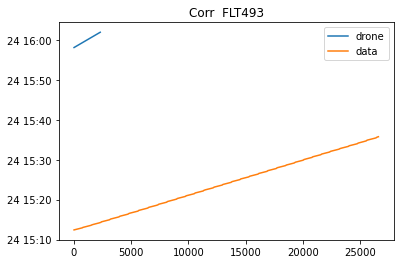

In [3]:

# Read the yaml for the flight(s) you're interested in in flys

cdat = '20210824T151215Z'

flys = ['493']

for fly in flys:
    if int(fly) < 537:
        mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
        gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
    else:
        mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
        gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

    sdir = os.listdir(mdir)[0]
    datadir=mdir+sdir+'/'
    print(sdir, datadir,gaindir)
    
    dronedir='/hirax/all_drone_data/datcon_csv/'
    dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite)

    print('DONE reading in drone data')
    print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])

    pu.Plot_Drone_Coordinates(dronetest0825,coo='xy')#,t_bounds=[tlb,tub])
    plt.show()
    #pu.Plot_Drone_Coordinates(dronetest0825,coo='xy',t_bounds=[2400,10200])
    print(cdat)
    
    ## Combine drone and correlator data

    
    print('start time: ', datetime.datetime.now())

    corrtest0825=corr.Corr_Data(Data_Directory=datadir,
                    Gain_Directory=gaindir,site_class=gbosite,
                    crossmap=[])

    
    
    print('end time: ', datetime.datetime.now())
    
    # putting checks in one cell now that I know I've mostly figured out the flight/corr file correspondence
    # This checks I copied and pasted ok :)

    ## plot their datetime arrays to check overlap
    
    title = "Corr  FLT" + str(fly)
    plot(dronetest0825.t_arr_datetime,label='drone')
    plot(corrtest0825.t_arr_datetime,label='data')
    plt.title(title)
    legend()
    plt.show()

Initializing CONCAT CLASS with active traceback using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210824T151215Z_yale_drone/corr/20210824T151241Z/
  --> FLY493.csv
Creating directory for saving traceback and analysis outputs:
  --> /hirax/GBO_Analysis_Outputs/FLY493_20210824T151215Z/
Concat initialized without previous config file...
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 0 elements
  --> drone timestamp axis contains 2292 elements


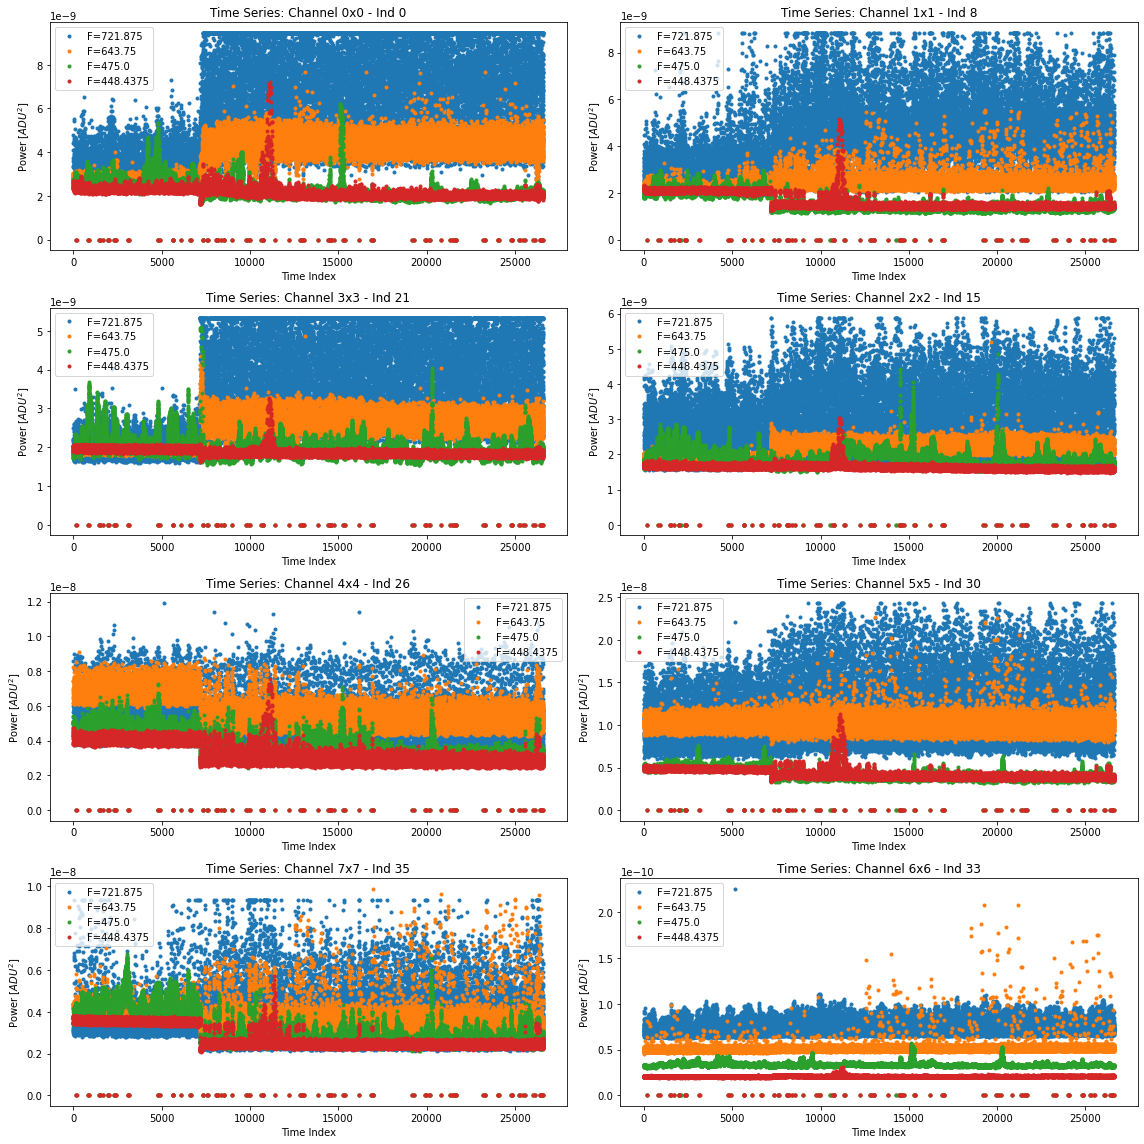

In [4]:
# Match drone and correlator data together, and plot a few frequencies

config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             load_yaml=False,traceback=True,save_traceback=True)
#concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,load_yaml=True,traceback=True,save_traceback=False)

pu.Plot_Time_Series(concattest0825,freqlist=[200,400,832,900]) # previously set to just 700

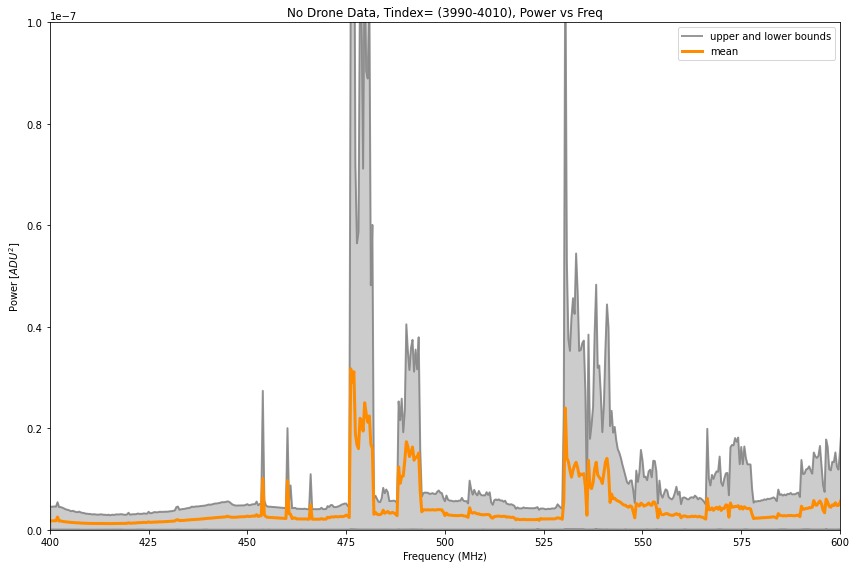

In [27]:
# Taking max, min, avg for drone off data as a function of frequency over several time indices
# And averaging together 

fig = plt.figure(figsize=(12, 8))   

def Plot_Time_Series2(corr_class,start,end,freqlist=None):
    
    if freqlist==None:
        freqlist= 800.0 * np.ones(1024) + (-400 / 1024.) * np.arange(1024)
        mins2=[]
        maxes2=[]
        avg2=[]
    
#     fig1=figure(figsize=(16,int(4*corr_class.n_channels/2)))
#     for i in range(corr_class.n_channels):
#         ax=fig1.add_subplot(int(corr_class.n_channels/2),2,i+1)
        for k in freqlist:
            freq_idx = np.where(corr_class.freq ==k)[0]
#             Going through frequencies and finding when corr_class has data 
            mins3=[]
            maxes3=[]
            avg3=[]
            
            for tindex in range (start,end):
                thing=corr_class.V[tindex, freq_idx]

                mins3.append(np.min(thing))
                maxes3.append(np.max(thing))
                avg3.append(np.mean(thing))
                               
        
            mins2.append(np.mean(mins3))
            maxes2.append(np.mean(maxes3))
            avg2.append(np.mean(avg3))
                
            
    plt.plot(freqlist,mins2,color='gray', alpha=0.8,linewidth='2',label='upper and lower bounds')
    plt.plot(freqlist,maxes2,color='gray', alpha=0.8,linewidth='2')
    plt.plot(freqlist,avg2,color='darkorange',linewidth=3,label='mean')
    plt.fill_between(freqs, mins2, maxes2, color='gray', alpha=0.4)
    plt.title('No Drone Data, Tindex= (3990-4010), Power vs Freq')
    plt.ylabel('Power [$ADU^2$]')
    plt.xlabel('Frequency (MHz)')
    plt.xlim(400,600)
    plt.ylim(0,1E-7)
    plt.legend()
    plt.show
    tight_layout()
mins2.append(((np.min(thing))*1E7)+.1)
            maxes2.append(((np.max(thing))*1E7)+.1)
            avg2.append(((np.mean(thing))*2.1E7))

                                       


Plot_Time_Series2(concattest0825,3990,4010)
    
    
    
# data = np.load('RFI (1).npz')
# spec = data['spec']

# freq = data['freq']
# plot(freq,(spec/1.2E14)-.15E-7)
# plt.xlim(400,600)


(400.0, 600.0)

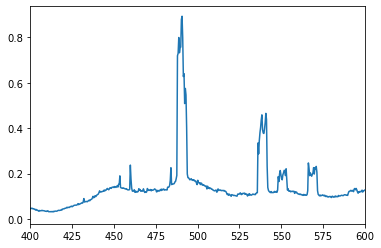

In [10]:
data = np.load('RFI (1).npz')
spec = data['spec']

freq = data['freq']
plot(freq,(spec/1E7)-.1)
plt.xlim(400,600)


(0.0, 7000.0)

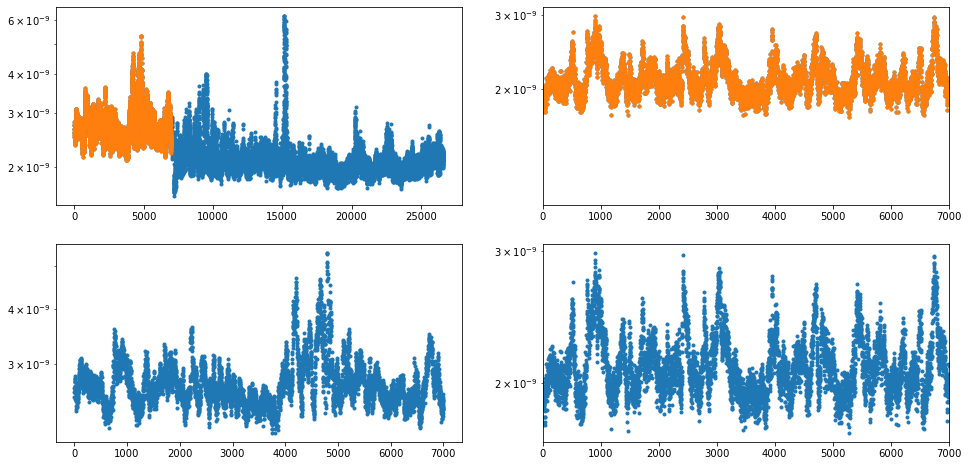

In [29]:
find=832#900
tclb = 0
tcub = 7000
fig=figure(figsize=(16,8))
for i in range(concattest0825.n_channels)[:2]:
    ax1=fig.add_subplot(2,2,i+1)
    ax2=fig.add_subplot(2,2,i+3)
    ax1.semilogy(concattest0825.t_index[:],concattest0825.V[:,find,concattest0825.chmap[i]],'.')
    for ax in [ax1,ax2]:
        ax.semilogy(concattest0825.t_index[tclb:tcub],concattest0825.V[tclb:tcub,find,concattest0825.chmap[i]],'.')
ax1.set_xlim(tclb,tcub)
ax2.set_xlim(tclb,tcub)


In [10]:
## OBJECTIVE 5E: concat Function: Main_Beam_Fitting

## Now we can do some analysis, since we have synchronized useful data. We can begin by fitting the main beam:
    ## You can specify the directory where you want the fit params to be output:
    ## fit_param_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
    ## This one sometimes takes a while, feel free to get a coffee or something.
concattest0825.Main_Beam_Fitting(fit_param_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/',
                                 FMB_ampbound=0.999)

Performing 2DGauss and Airy fits for [8]chans x [1024]freqs:
  --> Saving output fit parameters as an .npz filetype:
  --> FLY493_20210824T151215Z_ver_20230706T143851_2dGauss_and_Airy_Params.npz
